#   Прогнозирование оттока клиентов оператора связи

## Описание проекта

В общем виде **цель** поставлена таким образом: оператор связи хочет прогнозировать отток клиентов, для того, чтобы предлагать специальные условия клиентам из "группы риска". 

Данные о клиентах содержатся в 4 таблицах: это информация о договоре, некоторая социально-демографическая информация о клиенте, а также информация о подключении клиенту телефонных и интернет-услуг.

**Первичная задача** состоит в анализе данных и составлении плана работы на последующие этапы.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*). Также абонентам доступен ряд дополнительных интернет-услуг.

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Информация о договорах актуальна на 1 февраля 2020.

### Импорты библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
from phik import report
from phik.report import plot_correlation_matrix
import copy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import xgboost as xgb

import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cb
from catboost import CatBoostClassifier, Pool
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Описание и первичный анализ данных

Загрузим файлы и посмотрим на их содержимое. Последовательно обработаем данные из каждой таблицы.

### Таблица "contract"

In [2]:
try:
    contract = pd.read_csv('C:\\Users\\Мамуля\\Documents\\final_provider\\contract.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')

display(contract.info())
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Итак, в таблице **`contract`** видим следующие данные:
* `customerID` - номер абонента - как следует из постановки задачи, он объединяет все 4 таблицы.
* `BeginDate` - дата заключения договора, она представлена в формате object, но целесообразно привести её к формату date.
* `EndDate` - дата расторжения договора, если в столбце значение `No`, то, по всей видимости, договор не расторгался.
* `Type` - тип оплаты связи - помесячный или на 1-2 года.
* `PaperlessBilling` и `PaymentMethod` - информация в этих столбцах относится к способу оплаты услуг связи.
* `MonthlyCharges` - сколько абоненты платят за услуги связи в месяц. Тип данных в этом столбце соответствует содержимому.
* `TotalCharges` - сколько абонент успел суммарно заплатить за связь за время действия контракта.

В таблице **`contract`** нет пропущенных значений.

In [3]:
# переименуем столбцы
contract = contract.rename(columns={
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges'}
)

Также сразу переведём в числовой тип данных в столбце `total_charges`.

In [4]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'],
                                         errors='coerce')
# check
contract.dtypes

customer_id           object
begin_date            object
end_date              object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
dtype: object

#### Столбцы с текстовыми значениями

Посмотрим на значения столбцов и примем решение о том, как обработать представленные данные.

In [5]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

In [6]:
print(contract.loc[contract['paperless_billing'] == 'Yes']['customer_id'].count())
contract.pivot_table(index='payment_method', columns='paperless_billing', 
                                values='customer_id', aggfunc='count')

4171


paperless_billing,No,Yes
payment_method,,
Bank transfer (automatic),653,891
Credit card (automatic),640,882
Electronic check,623,1742
Mailed check,956,656


Из данных следует, что более половины клиентов предпочитают помесячную оплату услуг. Большинство клиентов также отдают предпочтение электронным счетам - и используют электронные способы оплаты. Около четверти всех клиентов настроили автооплату с карты или банковского счёта.

#### Даты заключения и расторжения договоров

Теперь обратим внимание на столбцы, содержащие даты. Целесообразно перевести их в соответствующий формат.

In [7]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], 
                                                      format='%Y-%m-%d')

# check
contract.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date                     object
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
dtype: object

In [8]:
contract['begin_date'].describe()

C:\Users\35DE~1\AppData\Local\Temp/ipykernel_8972/2458425963.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  contract['begin_date'].describe()


count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: begin_date, dtype: object

Данные охватывают период с октября 2013 по февраль 2020 года.

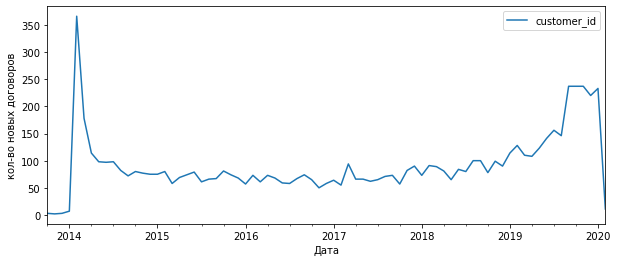

In [9]:
(contract
 .pivot_table(columns='begin_date', values='customer_id', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4))
)
plt.xlabel('Дата')
plt.ylabel('кол-во новых договоров');

Видим, что пик количества новых договоров пришёлся на начало 2014 года, с 2015 по середину 2018 количество новых договоров оставалось на уровне 50-100. Этап роста количества договоров начался в середине 2018 года, а в течение 2019 их ежемесячное количество росло довольно быстро.

Теперь обратим внимание на столбец `end_date`. В нём есть значения `No` - значит, абонент не разорвал договор.

Создадим новый столбец `has_quit` на основе данных в столбце `end_date`: если клиент не расторг договор, то значение будет 0, а если расторг, то 1.

In [10]:
contract['has_quit'] = np.where(contract['end_date']=='No', 0, 1)

# check
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,has_quit
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Целесообразно посмотреть, сколько абонентов расторгли договор.

In [11]:
print(contract['has_quit'].sum())
contract['has_quit'].sum() / contract['customer_id'].count() 

1869


0.2653698707936959

За 6 лет компания потеряла около 26,5% своих абонентов. Посмотрим, нет ли тендеций, зависящих от времени. Для этого переведём данные в столбце `end_date` в формат даты.

count                    1869
unique                      4
top       2019-11-01 00:00:00
freq                      485
first     2019-10-01 00:00:00
last      2020-01-01 00:00:00
Name: end_date, dtype: object


C:\Users\35DE~1\AppData\Local\Temp/ipykernel_8972/2991241142.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(contract['end_date'].describe())


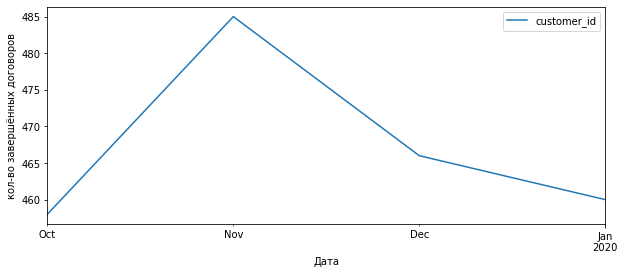

In [12]:
# переводим в формат datetime
contract['end_date'] = pd.to_datetime(contract['end_date'], 
                                                      format='%Y-%m-%d',
                                     errors='coerce')

#изучаем данные
print(contract['end_date'].describe())

# посмотирм на графике, сколько абонентов отключалось от тарифа в разные даты
(contract
 .pivot_table(columns='end_date', values='customer_id', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4))
)
plt.xlabel('Дата')
plt.ylabel('кол-во завершённых договоров');

Данные о разрыве договоров с оператором представлены только за 4 месяца - но необходимо отметить, что в этот период клиенты довольно активно покидали компанию, особенно, в ноябре 2019 года.

Зная, что клиенты расторгали договоры в октябре 2019 - январе 2020, интересно посмотреть, когда они заключали договоры с оператором, и есть ли ещё какие-либо особенности их договоров.

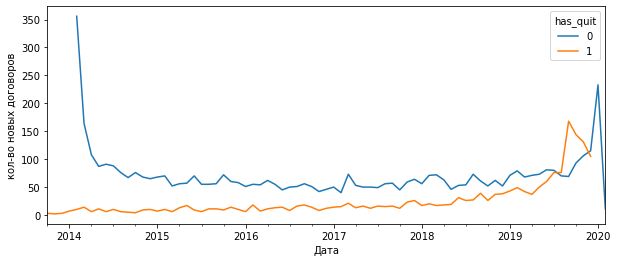

In [13]:
# выделим данные в отдельную таблицу для изучения
contract_quit = contract[contract['has_quit'] > 0]

# построим график, отражающий время заключения контракта
(contract
 .pivot_table(index='has_quit', columns='begin_date', values='customer_id', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4))
)
plt.xlabel('Дата')
plt.ylabel('кол-во новых договоров');

Интересными представляются две особенности:
* все, кто заключили договор до начала 2014 года, уже расторгли его, при этом среди ушедших клиентов не было ажиотажа в первые месяцы 2014 года - какой наблюдался на выборке в целом.
* довольно существенная доля тех, кто расторг договор в конце 2019-начале 2020 года, заключили его незадолго до этого.

In [14]:
contract_quit['type'].value_counts()

Month-to-month    1655
One year           166
Two year            48
Name: type, dtype: int64

Логично было предположить, что те, кто расторг договор с компанией, не заключали долгосрочный контракт. Это подтверждают данные. Посмотрим, есть ли какие-то особенности заключения контрактов и способов оплаты у ушедших клиентов.

In [15]:
contract_quit.pivot_table(index='payment_method', columns='paperless_billing', 
                                values='customer_id', aggfunc='count')

paperless_billing,No,Yes
payment_method,,
Bank transfer (automatic),72,186
Credit card (automatic),64,168
Electronic check,204,867
Mailed check,129,179


In [16]:
# ещё раз выведем сводную таблицу по всем данным
contract.pivot_table(index='payment_method', columns='paperless_billing', 
                                values='customer_id', aggfunc='count')

paperless_billing,No,Yes
payment_method,,
Bank transfer (automatic),653,891
Credit card (automatic),640,882
Electronic check,623,1742
Mailed check,956,656


Среди тех, кто в итоге расторг договор, значительно большая доля не получала бумажные счета. А кроме того, хорошо заметно, что эти клиенты гораздо реже оформляли автоматические платежи за услуги связи.

Изменим тип данных в столбце 'paperless_billing', заменив 'Yes' на 1 и 'No' на 0.

In [17]:
contract['paperless_billing'] = np.where(contract['paperless_billing']=='No', 0, 1).astype('float')

# check
contract['paperless_billing'].sum()

4171.0

#### Выручка от клиента

Теперь обратим внимание на помесячную и общую выручку.

In [18]:
contract[['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


In [19]:
# сравним показатели по всей выборке с показателями клиентов, расторгнувших договоры
contract[contract['has_quit'] > 0][['monthly_charges', 'total_charges']].describe()


,monthly_charges,total_charges
count,1869.000000,1869.000000
mean,74.441332,1531.796094
std,24.666053,1890.822994
min,18.850000,18.850000
25%,56.150000,134.500000
50%,79.650000,703.550000
75%,94.200000,2331.300000
max,118.350000,8684.800000


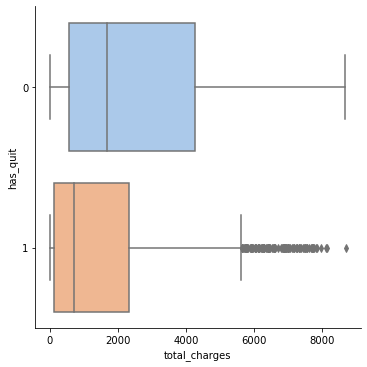

In [20]:
sns.catplot(y='has_quit', x='total_charges', kind="box", 
                data=contract, 
                orient='h', palette = 'pastel')

Видим, что ежемесячные платежи распределены в довольно узких рамках, явных выбросов нет, однако заметно, что у клиентов, которые приняли решение расторгнуть договор, средние ежемесячные платежи были несколько больше, чем в целом. 

Общая выручка от каждого клиента распределена значительно шире - в том числе, и в случае ушедших клиентов (хотя у этой группы она в среднем меньше, чем у выборки целиком). Посмотрим, много ли явных выбросов.

Также полезно для наглядности построить графики, на которых отдельно посмотреть распределение ежемесячных платежей и общих платежей для каждой группы клиентов.

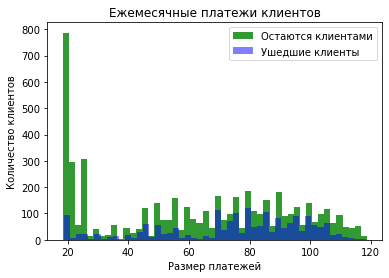

In [21]:
# средние платежи в месяц
fig, ax = plt.subplots()

plt.hist(contract[contract['has_quit'] < 1]['monthly_charges'], bins=50, 
           color='g', label='Остаются клиентами', alpha=0.8)
plt.hist(contract[contract['has_quit'] > 0]['monthly_charges'], bins=50,
          color='blue', label='Ушедшие клиенты', alpha=0.5)

ax.set_title('Ежемесячные платежи клиентов')
ax.set_xlabel('Размер платежей')
ax.set_ylabel('Количество клиентов')
plt.legend()
plt.show()

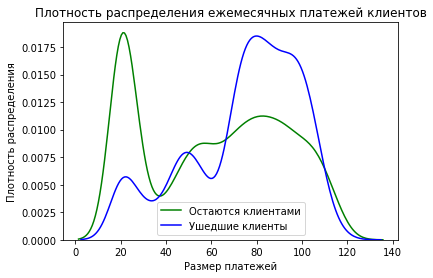

In [22]:
# плотность распределения средних платежей в месяц
fig, ax = plt.subplots()

sns.kdeplot(contract[contract['has_quit'] < 1]['monthly_charges'], 
           color='g', label='Остаются клиентами', alpha=0.8)
sns.kdeplot(contract[contract['has_quit'] > 0]['monthly_charges'],
          color='blue', label='Ушедшие клиенты', alpha=0.5)

ax.set_title('Плотность распределения ежемесячных платежей клиентов')
ax.set_xlabel('Размер платежей')
ax.set_ylabel('Плотность распределения')
plt.legend()
plt.show()

Хорошо видно, что те, кто расторгли договор с компанией, в большинстве случаев платили около 70-110 у.е. в месяц. Между тем, среди существующих абонентов немало тех, кто платит даже менее 30 у.е.

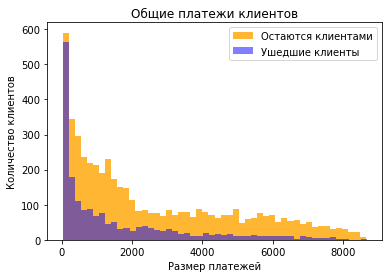

In [23]:
# сумма платежей клиентов
fig, ax = plt.subplots()

plt.hist(contract[contract['has_quit'] < 1]['total_charges'], bins=50, 
           color='orange', label='Остаются клиентами', alpha=0.8)
plt.hist(contract[contract['has_quit'] > 0]['total_charges'], bins=50,
          color='blue', label='Ушедшие клиенты', alpha=0.5)

ax.set_title('Общие платежи клиентов')
ax.set_xlabel('Размер платежей')
ax.set_ylabel('Количество клиентов')
plt.legend()
plt.show()

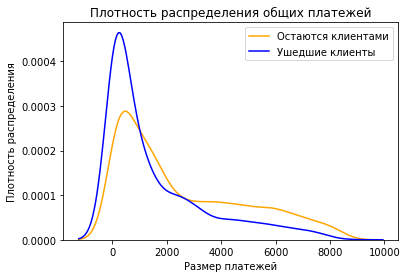

In [24]:
# плотность распределения суммы платежей
fig, ax = plt.subplots()

sns.kdeplot(contract[contract['has_quit'] < 1]['total_charges'], 
           color='orange', label='Остаются клиентами', alpha=0.8)
sns.kdeplot(contract[contract['has_quit'] > 0]['total_charges'],
          color='blue', label='Ушедшие клиенты', alpha=0.5)

ax.set_title('Плотность распределения общих платежей')
ax.set_xlabel('Размер платежей')
ax.set_ylabel('Плотность распределения')
plt.legend()
plt.show()

Наглядно отражается тот факт, что среди клиентов, расторгнувших договор с оператором, значительная доля тех, кто не успел потратить большую сумму на услуги связи. Напротив, долгосрочные клиенты чаще платили суммарно больше.

**Можно предположить, что решение о расторжении контракта абоненты принимали в том случае, если видели, что ежемесячные платежи для них высоки. Динамика заключения и расторжения договоров также показывает, что значительная доля клиентов отказались продлевать договор вскоре после его заключения. Это может свидетельствовать о том, что они были недовольны услугами связи. Кроме того, активный приток новых клиентов в течение 2019 года указывает на то, что, возможно, в этот период оператор проводил какие-либо акции или запустил новые предложения. По всей видимости, часть клиентов привлекли эти условия, но затем существенная доля новых абонентов разочаровались в операторе.**

### Таблица "personal"

Перейдём к таблице, которая содержит персональные данные клиентов.

In [25]:
try:
    personal = pd.read_csv('C:\\Users\\Мамуля\\Documents\\final_provider\\personal.csv')
except:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')

display(personal.info())
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [26]:
# сразу переименуем колонки для удобства
personal = personal.rename(columns={
    'customerID': 'customer_id',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents'}
)

Соответственно, эта таблица содержит, помимо общей колонки `customer_id`:
* `gender` - пол клиента,
* `senior_citizen` - является ли клиент пожилым человеком,
* `partner` - есть ли у клиента супруг(а),
* `dependents` - есть ли у клиента иждивенцы.

Пропусков в таблице нет, однако интересно узнать, сколько разных категорий есть в столбцах и сколько клиентов в каждой категории.

In [27]:
for column in personal[['gender', 'senior_citizen', 'partner', 'dependents']]:
    print('Колонка', column)
    print(personal[column].value_counts())
    print()

Колонка gender
Male      3555
Female    3488
Name: gender, dtype: int64

Колонка senior_citizen
0    5901
1    1142
Name: senior_citizen, dtype: int64

Колонка partner
No     3641
Yes    3402
Name: partner, dtype: int64

Колонка dependents
No     4933
Yes    2110
Name: dependents, dtype: int64



Видим, что среди клиентов примерно в равных долях присутствуют женщины и мужчины, а также замужние и незамужние. Доля пожилых клиентов сравнительно небольшая, а иждивенцы есть у чуть более трети клиентов.

Изменим тип данных в колонках, где есть ответы только 'Yes' и 'No' - пусть они будут 1 и 0.

In [28]:
for column in personal[['partner', 'dependents']]:
    personal.loc[personal[column] == 'No', column] = 0
    personal.loc[personal[column] == 'Yes', column] = 1
    # сразу переводим в тип float
    personal[column] = personal[column].astype(float)

#check
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,1.0,0.0
1,5575-GNVDE,Male,0,0.0,0.0
2,3668-QPYBK,Male,0,0.0,0.0
3,7795-CFOCW,Male,0,0.0,0.0
4,9237-HQITU,Female,0,0.0,0.0


### Таблица "internet"

Следующая таблица содержит данные об интернет-услугах, которые предоставляются клиентам.

In [29]:
try:
    internet = pd.read_csv('C:\\Users\\Мамуля\\Documents\\final_provider\\internet.csv')
except:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')

display(internet.info())
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [30]:
# сразу переименуем столбцы
internet = internet.rename(columns={
    'customerID': 'customer_id',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies'}
)

В этой таблице содержатся данные о том, подключены ли у абонентов какие-либо из 6 интернет-услуг оператора (и как реализовано подключение). Видим, что в таблице меньше значений, чем в таблицах о клиентах - вероятно, не все клиенты в принципе пользуются интернетом. 

Посмотрим, сколько абонентов пользуются различными услугами.

In [31]:
for column in internet[['internet_service', 'online_security', 
                        'online_backup', 'device_protection',
                       'tech_support', 'streaming_tv', 
                        'streaming_movies']]:
    print('Колонка', column)
    print(internet[column].value_counts())
    print()

Колонка internet_service
Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

Колонка online_security
No     3498
Yes    2019
Name: online_security, dtype: int64

Колонка online_backup
No     3088
Yes    2429
Name: online_backup, dtype: int64

Колонка device_protection
No     3095
Yes    2422
Name: device_protection, dtype: int64

Колонка tech_support
No     3473
Yes    2044
Name: tech_support, dtype: int64

Колонка streaming_tv
No     2810
Yes    2707
Name: streaming_tv, dtype: int64

Колонка streaming_movies
No     2785
Yes    2732
Name: streaming_movies, dtype: int64



Примерно равные доли абонентов, которые пользуются интернет-услугами, подписаны на онлайн-кинотеатр и телевидение. Остальные услуги менее популярны, но подписчиков всё равно достаточно много. Также необходимо отметить, что большая часть абонентов предпочитают подключение через оптоволоконный кабель.

Как представляется, клиенты отличаются по количеству подключенных интернет-услуг. В данной таблице оно может быть от 0 до 6. Для того, чтобы получить данные о количестве услуг, подключенных у каждого абонента, просуммируем значения в столбцах, однако предварительно переведём из в числовой вид.

In [32]:
for column in internet[['online_security', 
                        'online_backup', 'device_protection',
                       'tech_support', 'streaming_tv', 
                        'streaming_movies']]:
    internet.loc[internet[column] == 'No', column] = 0
    internet.loc[internet[column] == 'Yes', column] = 1
    # сразу переводим в тип float
    internet[column] = internet[column].astype(float)

#check
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,0.0,1.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,DSL,1.0,0.0,1.0,0.0,0.0,0.0
2,3668-QPYBK,DSL,1.0,1.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,DSL,1.0,0.0,1.0,1.0,0.0,0.0
4,9237-HQITU,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# создадим новый столбец с суммой
internet['num_services'] = internet.sum(axis=1)

# вычислим среднее количество услуг на абонента
print(internet['num_services'].mean())
# посмотрим, сколько абонентов с разным количеством услуг
internet['num_services'].value_counts()

2.601595069784303


C:\Users\35DE~1\AppData\Local\Temp/ipykernel_8972/4261896811.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  internet['num_services'] = internet.sum(axis=1)


3.0    1118
2.0    1033
1.0     966
4.0     852
0.0     693
5.0     571
6.0     284
Name: num_services, dtype: int64

Итак, вообще не подключены никакие услуги только у почти 700 пользователей. В то же время, и всеми или почти всеми услугами пользуются относительно малочисленные группы клиентов. В основном, у абонентов подключено от 1 до 3 услуг.

### Таблица "phone"

In [34]:
try:
    phone = pd.read_csv('C:\\Users\\Мамуля\\Documents\\final_provider\\phone.csv')
except:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

display(phone.info())
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


В этой таблице, помимо номера клиента, содержится только информация о том, есть ли у клиента возможность открывать параллельные линии во время звонка. Сразу обработаем эту таблицу и выясним, сколько таких клиентов.

In [35]:
# переименуем столбцы
phone = phone.rename(columns={
    'customerID': 'customer_id',
    'MultipleLines': 'multiple_lines'}
)

# выясним, у скольки клиентов есть возможность открывать несколько линий
phone['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

Значит, абоненты распределены по двум категориям примерно в равных долях.

In [36]:
# сразу изменим тип данных в столбце 'multiple_lines'
phone['multiple_lines'] = np.where(phone['multiple_lines']=='No', 0, 1).astype('float')

# check
phone['multiple_lines'].sum()

2971.0

## Общая таблица и анализ данных

### Подготовка данных для анализа

Для того, чтобы посмотреть, есть ли какие-либо ещё факторы (помимо времени заключения контракта и особенностей договора), влияющие на возможный уход клиента, целесообразно объединить таблицы. Проведём объединение по столбцу 'customer_id'.

In [37]:
data = contract.merge(personal, on='customer_id', how='left')
data = data.merge(internet, on='customer_id', how='left')
data = data.merge(phone, on='customer_id', how='left')

data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,has_quit,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,num_services,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1.0,Electronic check,29.85,29.85,0,Female,...,0.0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,0.0,Mailed check,56.95,1889.50,0,Male,...,0.0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1.0,Mailed check,53.85,108.15,1,Male,...,0.0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
3,7795-CFOCW,2016-05-01,NaT,One year,0.0,Bank transfer (automatic),42.30,1840.75,0,Male,...,0.0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,3.0,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1.0,Electronic check,70.70,151.65,1,Female,...,0.0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   float64       
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   has_quit           7043 non-null   int32         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   float64       
 12  dependents         7043 non-null   float64       
 13  internet_service   5517 non-null   object        
 14  online_s

In [39]:
# посмотрим, нет ли явных дубликатов
data.duplicated().sum()

0

Видим, что у нас есть пропуски в столбцах, которые отражают пользование услугами интернета и телефонии. Необходимо выяснить, что это за клиенты. Предположение таково, что они пользуются только услугами телефонной связи (либо только интернет-услугами). В таком случае для анализа целесообразно заменить пропуски на 0 - то есть, указать, что абонент не является пользователем конкретной услуги. Кроме того, на 0 в таком случае надо заменить и пропуски в созданном нами столбце `num_services` - по той же причине.

Однако перед этим интересно посмотреть на данные, в которых пропущено значение в столбце `total_charges`. Таких строк немного.

In [40]:
data[data['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,has_quit,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,num_services,multiple_lines
488,4472-LVYGI,2020-02-01,NaT,Two year,1.0,Bank transfer (automatic),52.55,NaN,0,Female,...,1.0,DSL,1.0,0.0,1.0,1.0,1.0,0.0,4.0,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,0.0,Mailed check,20.25,NaN,0,Male,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
936,5709-LVOEQ,2020-02-01,NaT,Two year,0.0,Mailed check,80.85,NaN,0,Female,...,1.0,DSL,1.0,1.0,1.0,0.0,1.0,1.0,5.0,0.0
1082,4367-NUYAO,2020-02-01,NaT,Two year,0.0,Mailed check,25.75,NaN,0,Male,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,0.0,Credit card (automatic),56.05,NaN,0,Female,...,1.0,DSL,1.0,1.0,1.0,1.0,1.0,0.0,5.0,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,0.0,Mailed check,19.85,NaN,0,Male,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3826,3213-VVOLG,2020-02-01,NaT,Two year,0.0,Mailed check,25.35,NaN,0,Male,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4380,2520-SGTTA,2020-02-01,NaT,Two year,0.0,Mailed check,20.00,NaN,0,Female,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5218,2923-ARZLG,2020-02-01,NaT,One year,1.0,Mailed check,19.70,NaN,0,Male,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6670,4075-WKNIU,2020-02-01,NaT,Two year,0.0,Mailed check,73.35,NaN,0,Female,...,1.0,DSL,0.0,1.0,1.0,1.0,1.0,0.0,4.0,1.0


Всё это - клиенты, которые заключили договоры на долгие сроки в последний месяц, за который у нас есть данные. Вероятно, их ежемесячный платёж автоматически появится в таблице в начале следующего месяца, поэтому на текущий момент целесообразно приравнять общую сумму их платежей к 0.

In [41]:
data['total_charges'] = data['total_charges'].fillna(0)

# check
data['total_charges'].describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

Чтобы выяснить, не являются ли клиенты с пропусками данных в отдельных столбцах "спящими", нет ли ошибки, посмотрим, платят ли они компании.

In [42]:
# возьмём пользователей с пропусками в столбце internet_service
data[data['internet_service'].isna()][['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,1526.000000,1526.000000
mean,21.079194,662.604784
std,2.164221,555.627705
min,18.250000,0.000000
25%,19.700000,157.825000
50%,20.150000,519.200000
75%,20.900000,1108.650000
max,26.900000,2006.950000


In [43]:
# изучим также пользователей с пропусками в столбце multiple_lines
data[data['multiple_lines'].isna()][['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,682.000000,682.000000
mean,42.028592,1496.033651
std,11.419585,1341.690864
min,23.450000,0.000000
25%,33.600000,298.512500
50%,40.575000,1149.025000
75%,50.737500,2458.587500
max,67.200000,4919.700000


Очевидно, что в строках с пропусками не находятся "спящие" абоненты, в таком случае, целесообразно заменить пропуски на нули.

In [44]:
data = data.fillna(0)

# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   float64       
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   has_quit           7043 non-null   int32         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   float64       
 12  dependents         7043 non-null   float64       
 13  internet_service   7043 non-null   object        
 14  online_s

Посмотрим, как распределены данные в итоговой таблице.

### Анализ социально-демографических отличий

Интересно выяснить, отличаются ли абоненты, которые решили расторгнуть договор с компанией, от действующих клиентов, по своим социально-демографическим характеристикам. Для того, чтобы это выяснить, посмотрим на сводную таблицу - в сравнении с данными по общей выборке.

In [45]:
# общая выборка
data[['senior_citizen', 'partner', 'dependents']].describe()

,senior_citizen,partner,dependents
count,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588
std,0.368612,0.499748,0.458110
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [46]:
soc_dem_data = pd.pivot_table(data, values=['senior_citizen', 'partner',
                                           'dependents'],
                             index='has_quit', aggfunc='mean')
soc_dem_data

,dependents,partner,senior_citizen
has_quit,,,
0,0.344801,0.528218,0.128721
1,0.174425,0.357945,0.254682


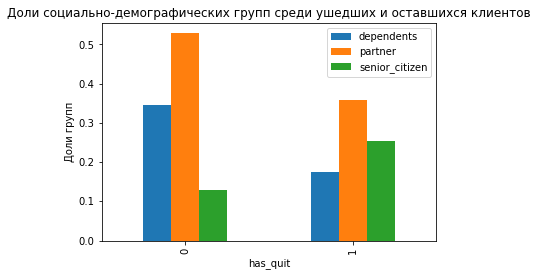

In [47]:
soc_dem_data.plot(kind='bar')
plt.ylabel('Доли групп')
plt.title('Доли социально-демографических групп среди ушедших и оставшихся клиентов')
plt.show()

Видим, что среди клиентов, разорвавших договор с компанией, реже встречаются те, у кого есть иждивенцы или супруги, но чаще - пожилые абоненты.

Посмотрим, есть ли какая-то связь между полом клиентов и фактом расторжения договора.

In [48]:
gen_data = pd.pivot_table(data, values='has_quit', 
                          index='gender', aggfunc='mean')
gen_data

,has_quit
gender,
Female,0.269209
Male,0.261603


Решение абонента расторгнуть договор практически не связано с его гендером.

Таким образом, из анализа социально-демографических характеристик, становится ясно, что более склонны разорвать договор были пенсионеры. Те же, кто имеет семью и детей, напротив, реже расторгали договор с оператором.

### Анализ использования услуг

Теперь посмотрим, насколько активно абоненты пользуются различными услугами - и как ими пользовались те, кто отказался продлевать договор с оператором.

In [49]:
serv_columns = ['internet_service', 'online_security', 'online_backup',
     'device_protection', 'tech_support', 'streaming_tv',
     'streaming_movies', 'multiple_lines', 'num_services']
data[serv_columns].describe()

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,num_services
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.421837,2.037910
std,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.493888,1.847682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [50]:
service_data = pd.pivot_table(data, values=serv_columns,
                             index='has_quit', aggfunc='mean')
service_data

,device_protection,multiple_lines,num_services,online_backup,online_security,streaming_movies,streaming_tv,tech_support
has_quit,,,,,,,,
0,0.362775,0.409934,2.135292,0.368380,0.333204,0.369927,0.365868,0.335137
1,0.291600,0.454789,1.768325,0.279829,0.157838,0.437667,0.435527,0.165864


Визуализируем данные без количества услуг (этот показатель соотносится с другой шкалой).

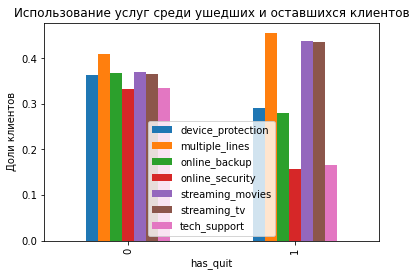

In [51]:
service_data = service_data.drop('num_services', axis=1)

service_data.plot(kind='bar')
plt.ylabel('Доли клиентов')
plt.title('Использование услуг среди ушедших и оставшихся клиентов')
plt.show()

В первую очередь, стоит обратить внимание на то, что **у людей, которые расторгли договор с компанией, было в среднем подключено меньше услуг, чем у абонентов, оставшихся клиентами**, а также меньше, чем по всей выборке. Это может говорить о том, что они заключили договор из-за конкретного предложения. Значимо реже ушедшие абоненты пользовались специфическими услугами:  онлайн-защитой, приоритетной технической поддержкой, защитой устройства и онлайн-бэкапом. 

С другой стороны, чаще они подключали возможность использовать несколько телефонных линий. Также они чаще подключали такие популярные услуги, как стриминговое ТВ и кино. Возможно, этих абонентов привлекли как раз какие-то из этих услуг, а затем они решили перейти к другим операторам.

### Поиск мультиколлинеарности

Целевым признаком, по всей видимости, будет столбец `has_quit`. Помня об этом, посмотрим, как данные соотносятся друг с другом.

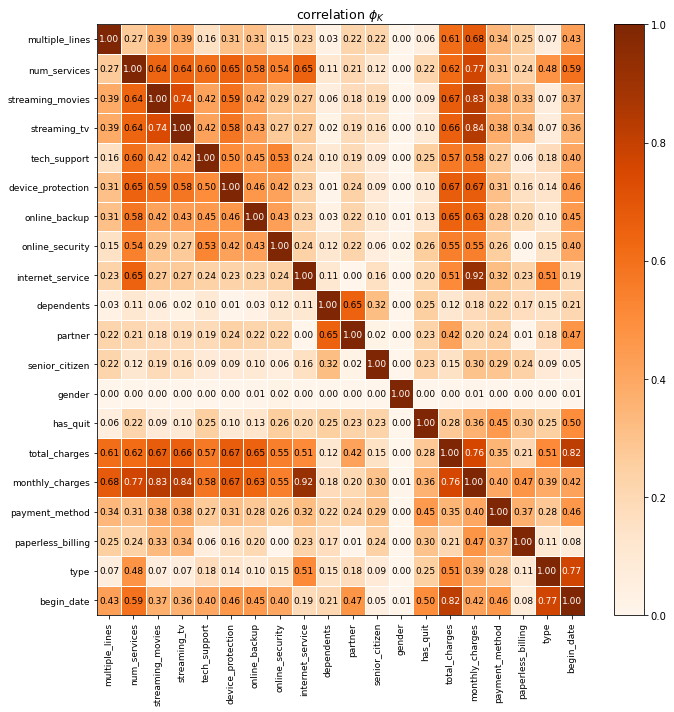

In [52]:
# для того, чтобы построить матрицу коэффициентов корреляции, 
# удалим из датасета столбцы "customer_id" и "end_date"
data_corr = data.drop(['end_date', 'customer_id'], axis=1)

# построим матрицу коэффициентов корреляции Phi_k
# и сразу отразим её визуально в виде тепловой карты
interval_cols = ['total_charges', 'monthly_charges', 'num_services']
corr_table = data_corr.phik_matrix(interval_cols=interval_cols).round(2)

plot_correlation_matrix(corr_table.values, 
                        x_labels=corr_table.columns, 
                        y_labels=corr_table.index, 
                        vmin=0, vmax=1, color_map="Oranges", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9, 
                        figsize=(10, 10))
plt.tight_layout()

Из карты коррелляций становится ясно, что сильно связаны с другими столбцами: `num_services`, `total_charges`, `monthly_charges`. Соответственно, на этапе подготовки данных к обучению потребуется удалить столбец `total_charges`: этот столбец даёт меньше информации о том, расторг ли клиент договор, чем `monthly_charges`. Колонки `num_services` в данных также не будет.

В остальном каких-либо "подозрительных" результатов не обнаруживается. Напротив, весьма логичной видится связь между размером ежемесячных платежей и отдельными услугами (интернетом, стриминговыми сервисами), а также, например, между общим размером платежей и датой заключения договора.

### Выводы

Проведённый анализ показал следующее:
* в таблице представлены данные о клиентах, которые заключали договоры с оператором связи с октября 2013 года. Отток клиентов стал происходить в октябре 2019 - январе 2020 года. За 4 месяца компания потеряла более 26% клиентов.
* значительная часть из этих клиентов сотрудничали с компанией недолго, при этом их тарифные планы зачастую предполагали довольно высокий уровень ежемесячных платежей (от 55 до 95 у.е.). Усиленный отток клиентов произошёл среди пенсионеров.
* большинство ушедших клиентов не заключали долгосрочные договоры и пользовались меньшим количеством услуг компании, чем те, кто остался лоялен провайдеру. Однако они значительно чаще были подписаны на стриминговые сервисы.
* эти данные позволяют сделать предположение о том, что в 2019 году оператор предпринял шаги для наращивания клиентской базы (возможно, предложил новые тарифы или услуги) - это подтверждается и более активным притоком клиентов в течение 2019 года. Однако часть новых клиентов либо оказались не удовлетворены качеством услуг, либо отказались от них из-за повышенной стоимости.

## Вопросы и план работы

**Цель работы:**

Учитывая предположение, что в ходе анализа данных был правильно определён целевой признак (и вынесен в столбец `has_quit`), а также поставленную цель - определить клиентов, которые могут в скором времени расторгнуть договор с оператором, задача второго этапа - это предложить **модель для проведения бинарной классификации**. 

**Вопросы/ уточнения:**
1. Дальнейший план работы строится на предположении, что в столбце `end_date` значения 'No' соответствуют случаям, когда клиент не расторг договор. Верно ли это?
2. Кроме того, в этом столбце содержатся даты только за 4 месяца (с октября 2019 по январь 2020) - это кажется несколько подозрительным и требует уточнения.
3. Какую метрику следует использовать для анализа точности модели и какого значения этой метрики нужно добиться?
4. Есть ли какие-либо ограничения на время обучения и предсказания модели?

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b>  1. Именно так<br>
2. Возможно это следствие неудачной акции, смены политики компании, будем считать, что все так и было<br>
3. ROC-AUC >0.85<br>
4. Ограничений нет</div>

**План работы:**

Для достижения цели предпримем следующие шаги:
1. Проведём финальную подготовку данных для обучения модели. Для этого удалим из данных признаки `num_services`, `total_charges`, `end_date` - эта информация лишняя для обучения алгоритма. Отделим целевой признак от остальных и разобём данные на тренировочную, валидационную и тестовую выборки.
2. Попробуем решить задачу классификации с помощью следующих алгоритмов: логистическая регрессия, случайный лес и градиентный бустинг (попробуем модели LightGBM и CatBoost). Данные для логистической регрессии и случайного леса предварительно обработаем: оставшиеся категориальные переменные закодируем с помощью техники OHE. Для LightGBM и CatBoost категориальные переменные кодировать таким образом не нужно.
3. Обучим модели, подберём оптимальные гиперпараметры. Оценим результаты обучения моделей, применяя заданную метрику, и выберем лучшую.
4. Проведём тестирование модели на тестовой выборке. Сделаем выводы.

## Обучение моделей

### Подготовка признаков для обучения моделей

Ещё раз "прочитаем" уже знакомые нам данные из всех четырёх таблиц и объединим их в одну.

In [53]:
# contract
try:
    contract_df = pd.read_csv('C:\\Users\\Мамуля\\Documents\\final_provider\\contract.csv')
except:
    contract_df = pd.read_csv('/datasets/final_provider/contract.csv')

# personal
try:
    personal_df = pd.read_csv('C:\\Users\\Мамуля\\Documents\\final_provider\\personal.csv')
except:
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv')

# internet
try:
    internet_df = pd.read_csv('C:\\Users\\Мамуля\\Documents\\final_provider\\internet.csv')
except:
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv')

# phone
try:
    phone_df = pd.read_csv('C:\\Users\\Мамуля\\Documents\\final_provider\\phone.csv')
except:
    phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

# объединение таблиц
df = contract_df.merge(personal_df, on='customerID', how='left')
df = df.merge(internet_df, on='customerID', how='left')
df = df.merge(phone_df, on='customerID', how='left')

# check
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Создадим столбец "has_quit", который будет содержать целевой признак.

In [54]:
df['has_quit'] = np.where(df['EndDate']=='No', 0, 1)

# check
df.loc[df['has_quit'] == 1]['customerID'].count()

1869

Удалим из датасета ненужные для работы модели столбцы, а также исправим типы данных.

**Примечание:** В ходе исследования были испробованы четыре варианта датасета. В первом случае в неизменном виде сохранялся столбец `BeginDate`. Во втором случае из этого столбца были получены два новых признака: год (`Year`) и месяц (`Month`) подключения абонента, а изначальный столбец был удалён. В третьем случае решено было оставить признаки "год" и "месяц" и удалить из датасета столбец `MonthlyCharges`, так как данные из него значительно корреллировали с другими признаками. 

Наконец, четвёртый вариант (финальный) состоял в том, чтобы оставить столбец `MonthlyCharges`, а также, вместо преобразования даты заключения контракта, вычислить количество дней, которые абонент является клиентом (`Duration`).

При каждом подходе качество работы моделей на кросс-валидации последовательно улучшалось, в особенности - при реализации последнего варианта.

In [55]:
# преобразование даты заключения контракта
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')

# преобразование даты расторжения контракта 
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')


df['Duration'] = (df['EndDate'] - df['BeginDate']) // np.timedelta64(1, 'D')

# обеспечим единообразие категориальных признаков
df['SeniorCitizen'] = df['SeniorCitizen'].astype('str')

# удалим ненужные столбцы
df = df.drop(['customerID', 'EndDate', 'BeginDate', 'TotalCharges', 
              'gender'], axis=1)


# check
df.dtypes

Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
SeniorCitizen        object
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
has_quit              int32
Duration              int64
dtype: object

Ещё раз обратим внимание на пропуски.

In [56]:
df.isnull().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
has_quit               0
Duration               0
dtype: int64

Поскольку мы предполагаем, что пропуски в колонках, связанных с услугами, означают, что клиент не подключал соответствующие услуги, заполним их значением "No".

In [57]:
df = df.fillna('No')

# check
display(df.head())
df.info()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,has_quit,Duration
0,Month-to-month,Yes,Electronic check,29.85,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,61
3,One year,No,Bank transfer (automatic),42.30,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,61


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   SeniorCitizen     7043 non-null   object 
 5   Partner           7043 non-null   object 
 6   Dependents        7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  MultipleLines     7043 non-null   object 
 15  has_quit          7043 non-null   int32  
 16  Duration          7043 non-null   int64  


Визуализируем признаки, чтобы понять, как они распределены.

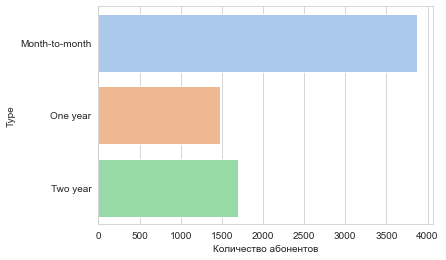

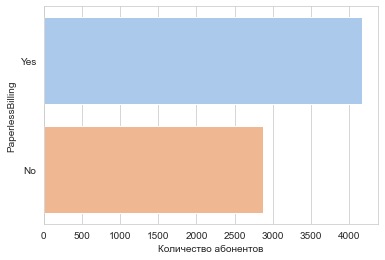

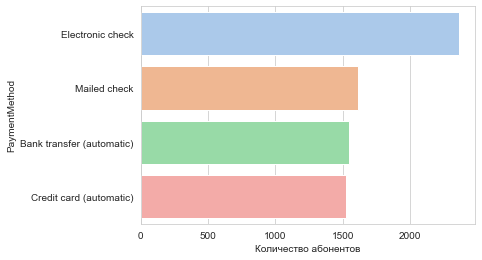

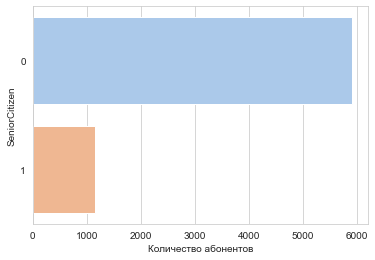

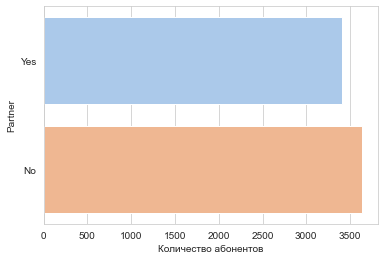

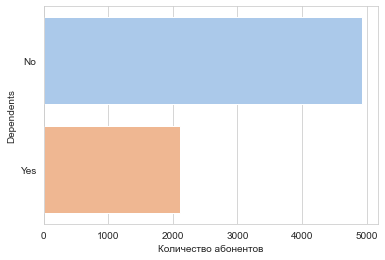

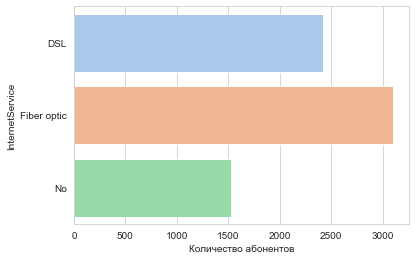

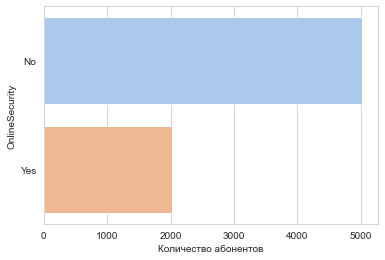

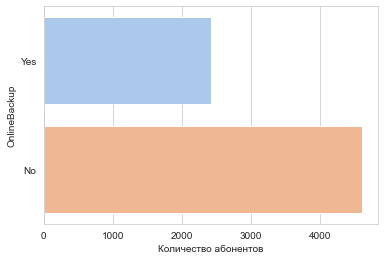

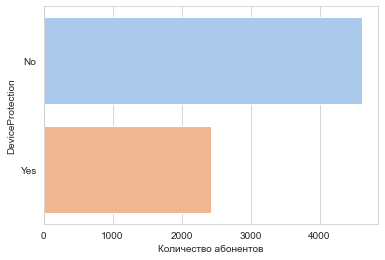

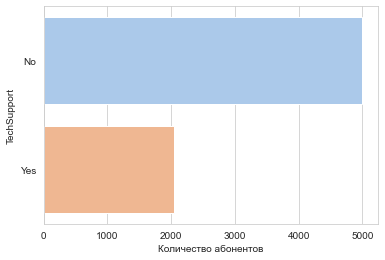

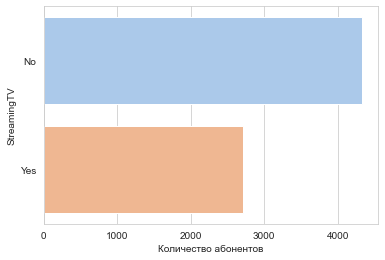

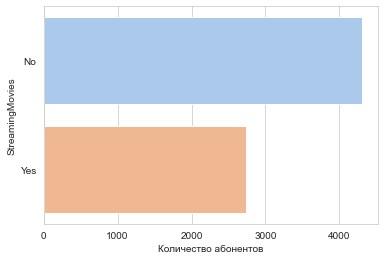

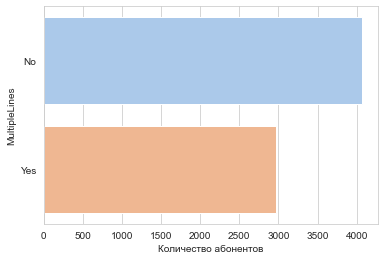

In [58]:
for column in df.select_dtypes(include=['object']).columns:
    sns.set_style('whitegrid')
    sns.countplot(y=column, data=df, palette='pastel')
    plt.xlabel('Количество абонентов')
    plt.ylabel(column)
    plt.show()

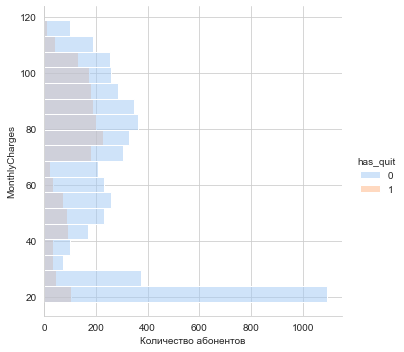

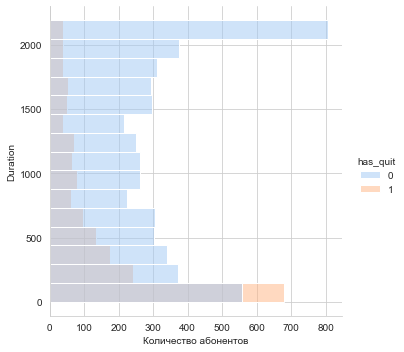

In [59]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    sns.set_style('whitegrid')
    sns.displot(y=column, data=df, hue='has_quit', palette='pastel')
    plt.xlabel('Количество абонентов')
    plt.ylabel(column)
    plt.show()

Теперь отделим целевой признак.

In [60]:
features = df.drop('has_quit', axis=1)
target = df['has_quit']

# check
features.shape

(7043, 16)

interval columns not set, guessing: ['MonthlyCharges', 'Duration']


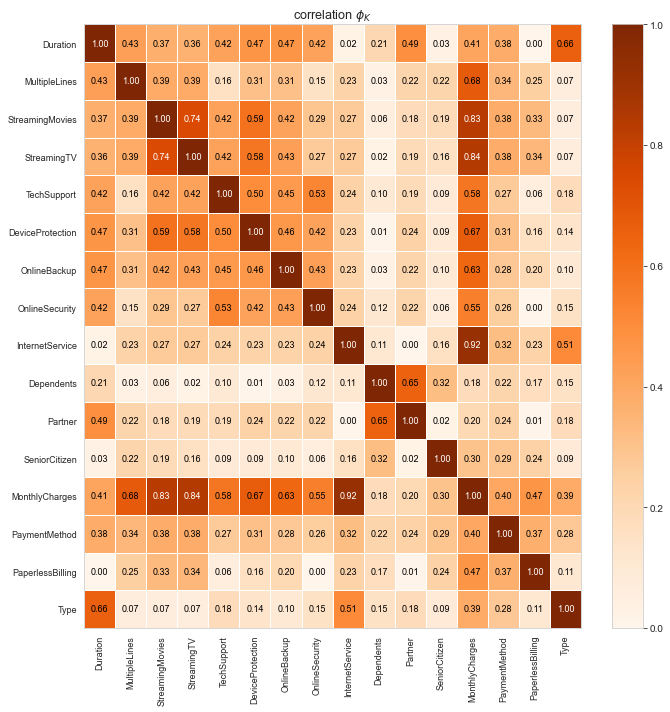

In [61]:
corr_table = features.phik_matrix().round(2)

plot_correlation_matrix(corr_table.values, 
                        x_labels=corr_table.columns, 
                        y_labels=corr_table.index, 
                        vmin=0, vmax=1, color_map="Oranges", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9, 
                        figsize=(10, 10))
plt.tight_layout()

Видим, что признак `MonthlyCharges` сильно связан с рядом других признаков. Однако эксперименты с его включением и исключением показали, что, если качество логистической регрессии при включении этого признака падает, то качество других моделей растёт - по всей видимости, они менее чувствительны к внутренним корреляциям признаков.

Разделим данные на обучающую, тестовую и валидационную выборки.

In [62]:
features_train, features_test, target_train, target_test, = train_test_split(
    features, target, test_size=0.25, random_state=300123)

# check
features_train.shape

(5282, 16)

In [63]:
# check
features_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Duration
4476,Month-to-month,No,Mailed check,20.90,0,No,No,No,No,No,No,No,No,No,No,30
2474,Month-to-month,Yes,Electronic check,106.35,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,1432
6077,Two year,No,Mailed check,113.95,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1888
2263,Month-to-month,Yes,Bank transfer (automatic),98.15,0,No,No,Fiber optic,Yes,Yes,Yes,Yes,No,Yes,No,184
6731,Two year,Yes,Bank transfer (automatic),19.55,0,No,No,No,No,No,No,No,No,No,No,730


In [64]:
# check
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 4476 to 6367
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   SeniorCitizen     5282 non-null   object 
 5   Partner           5282 non-null   object 
 6   Dependents        5282 non-null   object 
 7   InternetService   5282 non-null   object 
 8   OnlineSecurity    5282 non-null   object 
 9   OnlineBackup      5282 non-null   object 
 10  DeviceProtection  5282 non-null   object 
 11  TechSupport       5282 non-null   object 
 12  StreamingTV       5282 non-null   object 
 13  StreamingMovies   5282 non-null   object 
 14  MultipleLines     5282 non-null   object 
 15  Duration          5282 non-null   int64  
dtypes: float64(1), int64(1), object(14)
mem

Создадим пайплайн для подготовки данных.

In [65]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = features_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = features_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Логистическая регрессия

Несмотря на то, что метрика AUC-ROC не чувствительна к дисбалансу классов, укажем модели на то, что классы не сбалансированы (как мы помним, клиентов, которые расторгли договор, в 3 раза меньше, чем остальных).

In [66]:
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(
                         class_weight='balanced', solver='liblinear', 
                          random_state=300123))])

lr_cv = cross_validate(model_lr, features_train, target_train, cv=6, 
                     scoring='roc_auc',
                    return_train_score=True)

lr_scores = pd.DataFrame(lr_cv)

display(lr_scores)

# найдём среднее значение метрики, полученное на кросс-валидации
lr_scores['test_score'].mean()

,fit_time,score_time,test_score,train_score
0,0.042010,0.010001,0.842178,0.841670
1,0.039181,0.010012,0.823377,0.845708
2,0.038008,0.009002,0.840594,0.842082
3,0.025073,0.015626,0.840544,0.841695
4,0.046869,0.000000,0.847967,0.840244
5,0.042725,0.009002,0.839458,0.841939


0.8390195015230186

Результат логистической регрессии невысокий.

### Случайный лес

Зададим параметы для обучения модели RandomForest и проведём оценку на кросс-валидации. В данном случае также есть возможность указать на дисбаланс классов.

In [67]:
rf = RandomForestClassifier(class_weight='balanced', random_state=300123)

model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

params = { 
    'classifier__n_estimators': [140, 160, 180],
    'classifier__max_depth' : range(6, 12)}

grid = GridSearchCV(model_rf, params, cv=6, scoring='roc_auc')
grid.fit(features_train, target_train)


rf_scores = pd.DataFrame(grid.cv_results_)

rf_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.412317,0.012885,0.036003,0.004512,6,140,"{'classifier__max_depth': 6, 'classifier__n_es...",0.850373,0.836497,0.847308,0.846154,0.854669,0.846171,0.846862,0.005506,8
1,0.457854,0.008891,0.035510,0.004257,6,160,"{'classifier__max_depth': 6, 'classifier__n_es...",0.850569,0.836397,0.847764,0.845780,0.854890,0.846110,0.846918,0.005631,7
2,0.546904,0.062337,0.043258,0.006049,6,180,"{'classifier__max_depth': 6, 'classifier__n_es...",0.850909,0.836224,0.847758,0.845667,0.854268,0.845776,0.846767,0.005594,9
3,0.449447,0.015331,0.035273,0.001061,7,140,"{'classifier__max_depth': 7, 'classifier__n_es...",0.854292,0.839307,0.850156,0.847981,0.852910,0.844595,0.848207,0.005087,3
4,0.482381,0.009458,0.042156,0.005589,7,160,"{'classifier__max_depth': 7, 'classifier__n_es...",0.855311,0.838994,0.850029,0.848258,0.853512,0.844702,0.848468,0.005457,1
5,0.538504,0.010800,0.040199,0.000253,7,180,"{'classifier__max_depth': 7, 'classifier__n_es...",0.855671,0.837416,0.849422,0.848505,0.854201,0.844753,0.848328,0.006076,2
6,0.447764,0.012126,0.037431,0.004132,8,140,"{'classifier__max_depth': 8, 'classifier__n_es...",0.855188,0.837130,0.849802,0.849159,0.851756,0.844388,0.847904,0.005795,5
7,0.507692,0.012556,0.039884,0.000722,8,160,"{'classifier__max_depth': 8, 'classifier__n_es...",0.855634,0.836637,0.849782,0.848812,0.852288,0.845271,0.848071,0.006014,4
8,0.558887,0.021349,0.046203,0.001509,8,180,"{'classifier__max_depth': 8, 'classifier__n_es...",0.855581,0.835701,0.849642,0.848518,0.852375,0.845358,0.847862,0.006294,6
9,0.451100,0.004116,0.036429,0.007389,9,140,"{'classifier__max_depth': 9, 'classifier__n_es...",0.853856,0.833333,0.850566,0.846534,0.851943,0.842291,0.846421,0.006968,12


Выявим лучший результат - и какие параметры ему соответствуют.

In [68]:
display(rf_scores[rf_scores['rank_test_score'] == 1])
best_rf = rf_scores[rf_scores['rank_test_score'] == 1]['mean_test_score'].values[0]
best_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
4,0.482381,0.009458,0.042156,0.005589,7,160,"{'classifier__max_depth': 7, 'classifier__n_es...",0.855311,0.838994,0.850029,0.848258,0.853512,0.844702,0.848468,0.005457,1


0.8484678026914912

### XGBoost

XGBoost предоставляет возможность задать информацию о дисбалансе классов с помощью параметра `scale_pos_weight`, значение которого должно равняться результату деления количества наблюдений "0" на количество "1".

In [69]:
xg = xgb.XGBClassifier(random_state=300123, scale_pos_weight=2.77)

model_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xg)])

params = {'classifier__n_estimators': [80, 100, 120],
              'classifier__max_depth': [3, 5, 10],
         'classifier__learning_rate': [0.3, 0.25, 0.2]}

grid = GridSearchCV(model_xgb, params, cv=6, scoring='roc_auc')
grid.fit(features_train, target_train)

xgb_scores = pd.DataFrame(grid.cv_results_)
xgb_scores

[21:52:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:52:26] WARNING:

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.121065,0.005989,0.016416,1.768928e-03,0.3,3,80,"{'classifier__learning_rate': 0.3, 'classifier...",0.896354,0.892890,0.883911,0.897478,0.896291,0.876097,0.890503,0.007885,15
1,0.141530,0.002002,0.015626,4.701678e-07,0.3,3,100,"{'classifier__learning_rate': 0.3, 'classifier...",0.901895,0.895341,0.888697,0.899186,0.903398,0.881060,0.894929,0.007850,11
2,0.161483,0.006513,0.016859,2.758204e-03,0.3,3,120,"{'classifier__learning_rate': 0.3, 'classifier...",0.907030,0.897679,0.891752,0.903088,0.906334,0.883783,0.898277,0.008344,7
3,0.171887,0.009022,0.015626,3.486858e-07,0.3,5,80,"{'classifier__learning_rate': 0.3, 'classifier...",0.902591,0.899461,0.896694,0.917289,0.907545,0.886669,0.901708,0.009434,4
4,0.198903,0.006223,0.016458,1.859914e-03,0.3,5,100,"{'classifier__learning_rate': 0.3, 'classifier...",0.905142,0.900906,0.900053,0.915941,0.915003,0.887378,0.904070,0.009716,2
5,0.230072,0.011003,0.015626,5.675497e-07,0.3,5,120,"{'classifier__learning_rate': 0.3, 'classifier...",0.904322,0.905275,0.901910,0.917425,0.917652,0.886796,0.905564,0.010441,1
6,0.324321,0.012634,0.015626,1.946680e-07,0.3,10,80,"{'classifier__learning_rate': 0.3, 'classifier...",0.889477,0.875538,0.876847,0.888803,0.891064,0.882405,0.884022,0.006168,24
7,0.388047,0.010738,0.015626,8.885336e-08,0.3,10,100,"{'classifier__learning_rate': 0.3, 'classifier...",0.888012,0.875924,0.878128,0.886008,0.892656,0.880712,0.883573,0.005838,25
8,0.454911,0.013373,0.016318,1.546084e-03,0.3,10,120,"{'classifier__learning_rate': 0.3, 'classifier...",0.885874,0.874605,0.877641,0.884147,0.891097,0.881261,0.882438,0.005408,26
9,0.125009,0.009022,0.010417,7.366061e-03,0.25,3,80,"{'classifier__learning_rate': 0.25, 'classifie...",0.892214,0.885338,0.877941,0.892565,0.896833,0.875783,0.886779,0.007802,22


In [70]:
display(xgb_scores[xgb_scores['rank_test_score'] == 1])
best_xgb = xgb_scores[xgb_scores['rank_test_score'] == 1]['mean_test_score'].values[0]
best_xgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
5,0.230072,0.011003,0.015626,5.675497e-07,0.3,5,120,"{'classifier__learning_rate': 0.3, 'classifier...",0.904322,0.905275,0.90191,0.917425,0.917652,0.886796,0.905564,0.010441,1


0.9055635007973054

### Градиентный бустинг LightGBM

In [71]:
lgb = LGBMClassifier(objective='binary', random_state=300123)

model_lgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lgb)])

params = { 
    'classifier__num_iterations': [300, 320, 350],
    'classifier__max_depth' : [-3, -4, -5],
    'classifier__num_leaves' : [6, 8, 10],
    'classifier__learning_rate' : [0.3, 0.2, 0.1]}

grid = GridSearchCV(model_lgb, params, cv=6, scoring='roc_auc')
grid.fit(features_train, target_train)


lgb_scores = pd.DataFrame(grid.cv_results_)

lgb_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__num_iterations,param_classifier__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.126920,0.014978,0.010417,7.366089e-03,0.3,-3,300,6,"{'classifier__learning_rate': 0.3, 'classifier...",0.917749,0.905315,0.907897,0.906906,0.915301,0.890793,0.907327,0.008662,19
1,0.133775,0.012724,0.015626,6.696502e-07,0.3,-3,300,8,"{'classifier__learning_rate': 0.3, 'classifier...",0.918821,0.897739,0.898675,0.908401,0.915629,0.894535,0.905633,0.009268,28
2,0.149428,0.009051,0.013021,5.823307e-03,0.3,-3,300,10,"{'classifier__learning_rate': 0.3, 'classifier...",0.914452,0.904915,0.905516,0.906760,0.910592,0.885271,0.904584,0.009239,40
3,0.125008,0.009022,0.013022,5.823431e-03,0.3,-3,320,6,"{'classifier__learning_rate': 0.3, 'classifier...",0.917769,0.905095,0.909118,0.905726,0.916050,0.892940,0.907783,0.008182,13
4,0.141528,0.009241,0.015627,7.986924e-07,0.3,-3,320,8,"{'classifier__learning_rate': 0.3, 'classifier...",0.918908,0.894382,0.900743,0.908107,0.914873,0.892863,0.904979,0.009821,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.140671,0.000083,0.010418,7.366426e-03,0.1,-5,320,8,"{'classifier__learning_rate': 0.1, 'classifier...",0.908571,0.893390,0.902731,0.904115,0.902906,0.886682,0.899733,0.007382,67
77,0.158980,0.017454,0.013022,5.823733e-03,0.1,-5,320,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.910183,0.899507,0.900623,0.904365,0.909060,0.888960,0.902116,0.007077,58
78,0.138030,0.010738,0.007813,7.813176e-03,0.1,-5,350,6,"{'classifier__learning_rate': 0.1, 'classifier...",0.903330,0.892604,0.902321,0.905202,0.900090,0.883659,0.897868,0.007506,73
79,0.154919,0.019276,0.013235,5.937204e-03,0.1,-5,350,8,"{'classifier__learning_rate': 0.1, 'classifier...",0.909670,0.894555,0.905392,0.904969,0.905194,0.888538,0.901387,0.007345,64


In [72]:
display(lgb_scores[lgb_scores['rank_test_score'] == 1])
best_lgb = lgb_scores[lgb_scores['rank_test_score'] == 1]['mean_test_score'].values[0]
best_lgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__num_iterations,param_classifier__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
33,0.138498,0.017634,0.013023,0.005824,0.2,-3,350,6,"{'classifier__learning_rate': 0.2, 'classifier...",0.913187,0.905255,0.908424,0.91321,0.916946,0.896274,0.908883,0.006765,1
42,0.135425,0.007367,0.007813,0.007813,0.2,-4,350,6,"{'classifier__learning_rate': 0.2, 'classifier...",0.913187,0.905255,0.908424,0.91321,0.916946,0.896274,0.908883,0.006765,1
51,0.131110,0.011417,0.007813,0.007813,0.2,-5,350,6,"{'classifier__learning_rate': 0.2, 'classifier...",0.913187,0.905255,0.908424,0.91321,0.916946,0.896274,0.908883,0.006765,1


0.9088826627359822

### CatBoostClassifier

In [73]:
cb = CatBoostClassifier(verbose=100, random_state=300123)

model_cb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', cb)])

params = { 
    'classifier__iterations': [100, 120, 140],
    'classifier__depth' : [4, 5, 6],
    'classifier__learning_rate' : [0.4, 0.3, 0.2]}


grid_cb = GridSearchCV(model_cb, params, cv=6, scoring='roc_auc')
grid_cb.fit(features_train, target_train)


0:	learn: 0.5031840	total: 149ms	remaining: 14.7s
99:	learn: 0.2256989	total: 385ms	remaining: 0us
0:	learn: 0.5029213	total: 2.53ms	remaining: 250ms
99:	learn: 0.2225057	total: 240ms	remaining: 0us
0:	learn: 0.5139868	total: 2.2ms	remaining: 218ms
99:	learn: 0.2229738	total: 235ms	remaining: 0us
0:	learn: 0.5131004	total: 2.27ms	remaining: 225ms
99:	learn: 0.2242161	total: 235ms	remaining: 0us
0:	learn: 0.5037144	total: 2.28ms	remaining: 226ms
99:	learn: 0.2248005	total: 238ms	remaining: 0us
0:	learn: 0.5147205	total: 2.26ms	remaining: 224ms
99:	learn: 0.2213939	total: 236ms	remaining: 0us
0:	learn: 0.5360875	total: 2.25ms	remaining: 223ms
99:	learn: 0.2504652	total: 232ms	remaining: 0us
0:	learn: 0.5357710	total: 2.27ms	remaining: 224ms
99:	learn: 0.2405347	total: 236ms	remaining: 0us
0:	learn: 0.5454038	total: 2.26ms	remaining: 224ms
99:	learn: 0.2490983	total: 238ms	remaining: 0us
0:	learn: 0.5445533	total: 2.22ms	remaining: 220ms
99:	learn: 0.2540364	total: 243ms	remaining: 0us
0:

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['MonthlyCharges', 'Duration'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner',
       'D...nlineSecurity', 'OnlineBack

In [74]:
cb_scores = pd.DataFrame(grid_cb.cv_results_)
display(cb_scores[cb_scores['rank_test_score'] == 1])
best_cb = cb_scores[cb_scores['rank_test_score'] == 1]['mean_test_score'].values[0]
best_cb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__depth,param_classifier__iterations,param_classifier__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
6,0.500652,0.086385,0.020922,0.005305,4,140,0.4,"{'classifier__depth': 4, 'classifier__iteratio...",0.921668,0.90958,0.917942,0.920177,0.938943,0.909686,0.919666,0.009833,1


0.9196661274754664

### Сравнение результатов

In [75]:
all_scores = pd.DataFrame(data=[['LogisticRegression', lr_scores['test_score'].mean()],
                                ['RandomForest', best_rf],
                          ['LightGBM', best_lgb],
                         ['XGBoost', best_xgb],
                         ['CatBoost', best_cb],],
                         columns=['Модель', 'AUC-ROC'])

all_scores

,Модель,AUC-ROC
0,LogisticRegression,0.839020
1,RandomForest,0.848468
2,LightGBM,0.908883
3,XGBoost,0.905564
4,CatBoost,0.919666


Таким образом, наилучшее качество даёт модель CatBoostClassifier с параметрами: learning rate = 0.4, num_iterations = 140, depth = 4. Запустим модель на тестовой выборке.

## Тестирование лучшей модели

In [76]:
cb = CatBoostClassifier(verbose=100, iterations=140, depth=4, 
                        learning_rate=0.4, random_state=300123)

model_cb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', cb)])

model_cb.fit(features_train, target_train)

predictions_prob = model_cb.predict_proba(features_test)

probabilities_one = predictions_prob[:, 1]

roc_auc = roc_auc_score(target_test, probabilities_one)

roc_auc

0:	learn: 0.5140722	total: 2.81ms	remaining: 391ms
100:	learn: 0.2287921	total: 286ms	remaining: 110ms
139:	learn: 0.2032765	total: 393ms	remaining: 0us


0.9319353327085287

Модель CatBoost показала хороший результат на тестовой выборке.

Отобразим результаты наглядно.

''

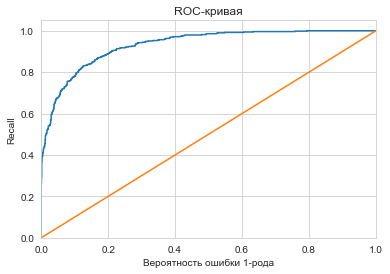

In [77]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('Вероятность ошибки 1-рода')
plt.ylabel('Recall')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
;

Построим матрицу ошибок.

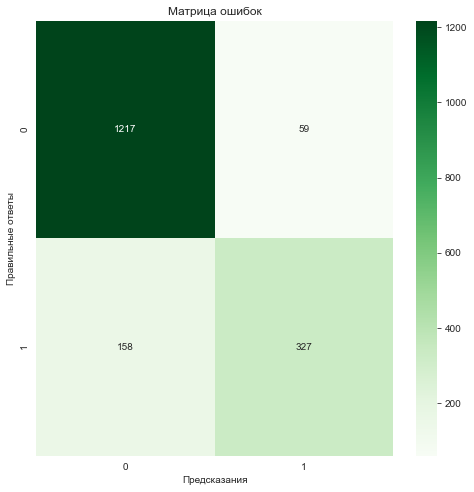

In [78]:
predictions = model_cb.predict(features_test)
matrix = confusion_matrix(target_test, predictions)

plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True, cmap='Greens', 
            fmt='d').set(title='Матрица ошибок', 
                         xlabel='Предсказания', 
                         ylabel='Правильные ответы')
plt.show();

Итак, верно предсказаны 1217 случаев, когда абонент не расторг договор, и 327 случаев расторжения договора. В целом заметно, что предсказание "1" модели удаётся сделать значительно хуже, чем предсказание "0".

Также интересно выяснить, какие признаки вносили наибольший вклад в определение класса. Для этого воспользуемся встроенной функцией CatBoost.

In [79]:
cat_features = features_train.select_dtypes(include=['object']).columns.values
cat_features

model_cb = CatBoostClassifier(cat_features=cat_features, verbose=100,
                              iterations=140, depth=4,
                              learning_rate=0.4, random_state=300123)

model_cb.fit(features_train, target_train)
model_cb.get_feature_importance(prettified=True)

0:	learn: 0.5741422	total: 25.5ms	remaining: 3.54s
100:	learn: 0.3256351	total: 1.51s	remaining: 582ms
139:	learn: 0.3067400	total: 2.08s	remaining: 0us


,Feature Id,Importances
0,Duration,54.745712
1,MonthlyCharges,13.185067
2,Type,13.168752
3,InternetService,4.662434
4,PaymentMethod,2.977396
5,TechSupport,2.785840
6,PaperlessBilling,1.918207
7,SeniorCitizen,1.265555
8,StreamingMovies,1.163370
9,OnlineSecurity,1.040548


Оказалось, что наиболее важным признаком является количество дней, которые абонент сотрудничает с оператором, на втором месте - тип контракта и размер ежемесячных платежей. 

## Выводы - отчёт по исследованию

**На первом этапе** был выполнен исследовательский анализ предоставленных данных. Он показал, что договор с оператором до 1 февраля 2020 года расторгли примерно 26% клиентов, причём значительная часть из них сделали это вскоре после заключения договора – и на пике притока клиентов во второй половине 2019 года. Как правило, ушедшие клиенты не заключали долгосрочные договоры с компанией, но ежемесячно платили в среднем больше, чем оставшиеся абоненты. Кроме того, более склонны разорвать договор были пенсионеры, а, например, с гендером клиентов их решение никак не было связано.

В целом, использование услуг компании было равномерно (доли пользователей не очень отличались от долей тех, кому отдельные услуги не были подключены), не наблюдается и значительных различий в социально-демографических характеристиках клиентов (за исключением малой доли пенсионеров).

**На втором этапе** была проведена подготовка признаков для обучения моделей классификации:
1. Таблицы были объединены по `CustomerID`.
2. Был создан столбец `has_quit`, содержащий целевой признак. В целом, дисбаланс классов присутствует, но не является большой проблемой (классы распределены примерно 1:3).
3. Из данных о дате заключения контракта и дате его расторжения (или принятого за финальную дату 01.02.2020) был создан столбец, содержащий информацию о количестве дней, в течение которых абонент являлся клиентом компании.
4. Были удалены столбцы 'customerID', 'EndDate', 'BeginDate', 'TotalCharges', 'gender', которые не нужны для обучения моделей. Решение о том, какие признаки оставить в датасете, было принято по итогам эксперимента.
5. Пропуски в данных находились в столбцах о подключении отдельных услуг – они были заполнены на значение `No`, что соответствует смыслу.
6. Целевой признак был отделён от остальных, проведено исследование признаков на внутреннюю корреляцию с помощью коэффициента PhiK.
7. Данные были разделены на обучающую и тестовую выборки, построен пайплайн для обработки данных.

В результате решено было оставить для обучения моделей столбцы: 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges','SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Duration'.

Далее проводилось обучение, подбор гиперпараметров и кросс-валидация на 5 моделях:
1. Логистическая регрессия,
2. Случайный лес,
3. XGBoost,
4. LightGBM,
5. CatBoost.

Во всех случаях отбиралась лучшая попытка по метрике AUC-ROC.
**Наилучшее качество** было получено моделью CatBoostClassifier с параметрами: learning rate = 0.4, num_iterations = 140, depth = 4. 

На тестовой выборке эта модель показала качество по метрике AUC-ROC 0.93. Модель дала 1213 истинно положительных и 288 истинно негативных ответов (из 1761 наблюдения в тестовой выборке). Наиболее важные признаки – продолжительность сотрудничества клиента и оператора, сумма ежемесячного платежа и тип контракта.

**В прикладном плане** (для задачи компании) это означает, что наибольшие усилия целесообразно прикладывать для того, чтобы повысить лояльность новых клиентов, оправдать их ожидания (в частности, от новых предложений) и сподвигнуть их к заключению долгосрочного договора.



### Ответы на вопросы

**Соответствие плану работы:**
1. Финальная подготовка признаков была проведена. Перечисленные в плане работы признаки `num_services`, `total_charges`, `end_date` действительно были удалены, как и столбец `CustomerID`. Валидационная выборка не понадобилась, так как подбор параметров и проверка качества моделей проводилась на кросс-валидации.
2. В исследовании участвовали в итоге 5 моделей, а не 4, как предполагалось. Модели на основе алгоритма градиентного бустинга (XGBoost, LightGBM, CatBoost) показали значительно более высокое качество по метрике AUC-ROC, чем более простые модели (логистическая регрессия и случайный лес). Подготовка признаков для моделей проводилась автоматически, специфической обработки данных для LightGBM и CatBoost не потребовалось.
3. Обучение моделей, подбор параметров и сравнение результатов прошли в соответствии с планом работы.
4. Лучшая модель была выбрана и протестирована также в соответствии с планом. Кроме того, была выявлена значимость признаков для классификации, построена матрица ошибок.

**Основные трудности:**
1. Работа по выявлению нужных признаков оказалась более сложной, чем предполагалось ранее. Так, для достижения требуемого качества предсказаний пришлось экспериментировать с тем, как обозначить для моделей длительность сотрудничества клиентов с оператором - предварительный анализ данных указывал на важность этого признака (что подтвердилось).
2. На последнем этапе работы возникла сложность с определением значимости признаков. Поскольку для обработки данных и классификации использовался пайплайн, а признаки поступали в модель уже в преобразованном OHE виде, то задача не решалась указанием на шаг пайплайна. Пришлось ещё раз обучить модель на признаках, закодированных вручную - это могло повлиять на оценку значимости.

**Ключевые шаги:**
* Ключевым для решения задачи оказался подробный анализ данных: он позволил заранее сформировать представление о том, какие признаки будут значимыми для классификации, а какие - не понадобятся (анализ позволил в общих чертах сформулировать причины оттока клиентов).
* Второй ключевой этап - это эксперимент с признаками, используемыми для работы моделей.

Подробная информация об **отобранных признаках**, **конфигурации итоговой модели и её качестве** содержится изложенных выше выводах по исследованию.